In [1]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import det_curve


In [2]:
GENDERS = ["Male", "Female"]
DURATIONS = ["5s", "10s", "15s"]
COMPONENTS = [16, 32, 64, 128, 256, 512]

MFCC_ROOT = r"./MFCC/Speakers"
MODEL_ROOT = r"./GMM_Models/Speakers"

In [3]:
def load_mfcc(path):
    return np.genfromtxt(path, delimiter=',', dtype=float, autostrip=True)

def get_speaker_id(filename):
    return filename.split("_")[0]

def gmm_score(gmm, mfcc):
    return np.mean(gmm.score_samples(mfcc))


In [4]:
def collect_test_segments(gender, duration):
    segments = []

    base = os.path.join(MFCC_ROOT, gender)

    for speaker in os.listdir(base):
        sp_path = os.path.join(base, speaker)

        for lang in os.listdir(sp_path):
            test_dir = os.path.join(sp_path, lang, "test")
            if not os.path.isdir(test_dir):
                continue

            for f in os.listdir(test_dir):
                if f.endswith(".mfcc") and duration in f:
                    segments.append({
                        "speaker": get_speaker_id(f),
                        "mfcc": load_mfcc(os.path.join(test_dir, f))
                    })

    return segments


In [5]:
def load_models(gender, n_components):
    models = {}
    base = os.path.join(MODEL_ROOT, gender)

    for speaker in os.listdir(base):
        model_path = os.path.join(
            base, speaker, "1min", f"{speaker}_{n_components}.gmm"
        )

        if os.path.exists(model_path):
            models[speaker] = joblib.load(model_path)

    return models


In [6]:
def compute_fa_fr_curves(segments, models, thresholds):
    fa = np.zeros(len(thresholds))
    fr = np.zeros(len(thresholds))

    impostor_trials = 0
    genuine_trials = 0

    for seg in segments:
        id_seg = seg["speaker"]

        for id_mod, gmm in models.items():
            score = gmm_score(gmm, seg["mfcc"])

            is_genuine = (id_seg == id_mod)

            if is_genuine:
                genuine_trials += 1
            else:
                impostor_trials += 1

            for i, th in enumerate(thresholds):
                if score > th and not is_genuine:
                    fa[i] += 1
                elif score <= th and is_genuine:
                    fr[i] += 1

    return fa / impostor_trials, fr / genuine_trials



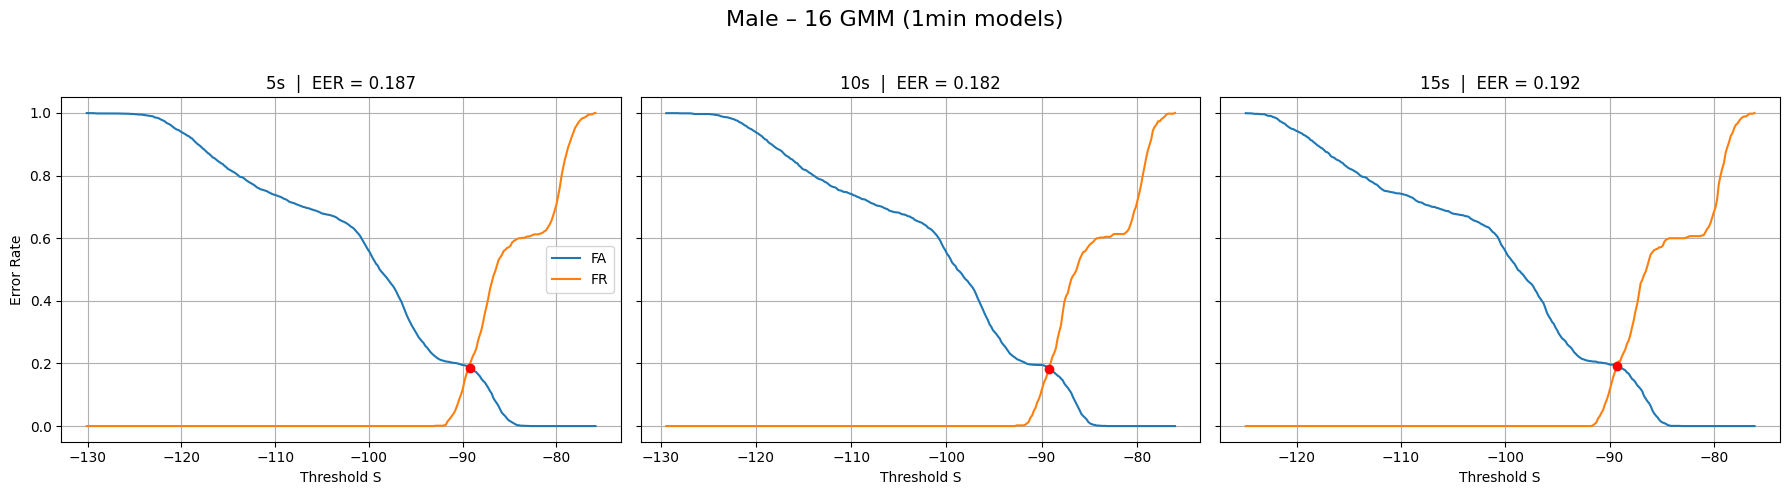

Finished: Male – 16 GMM


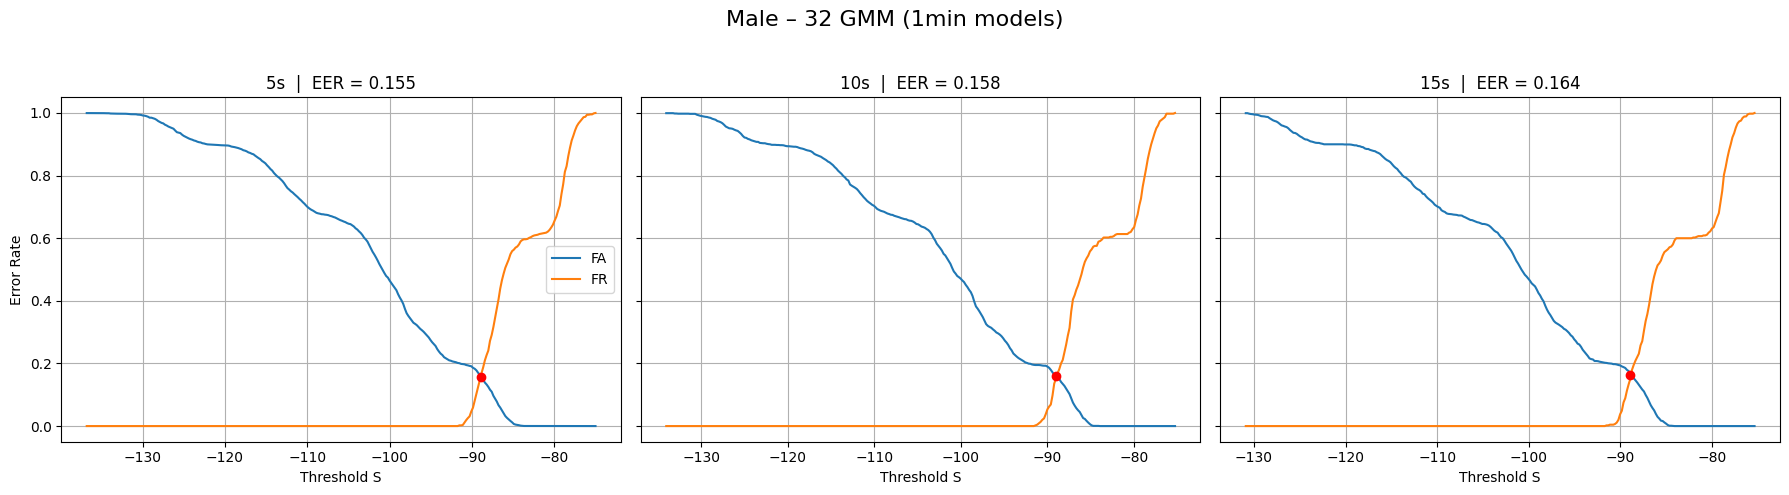

Finished: Male – 32 GMM


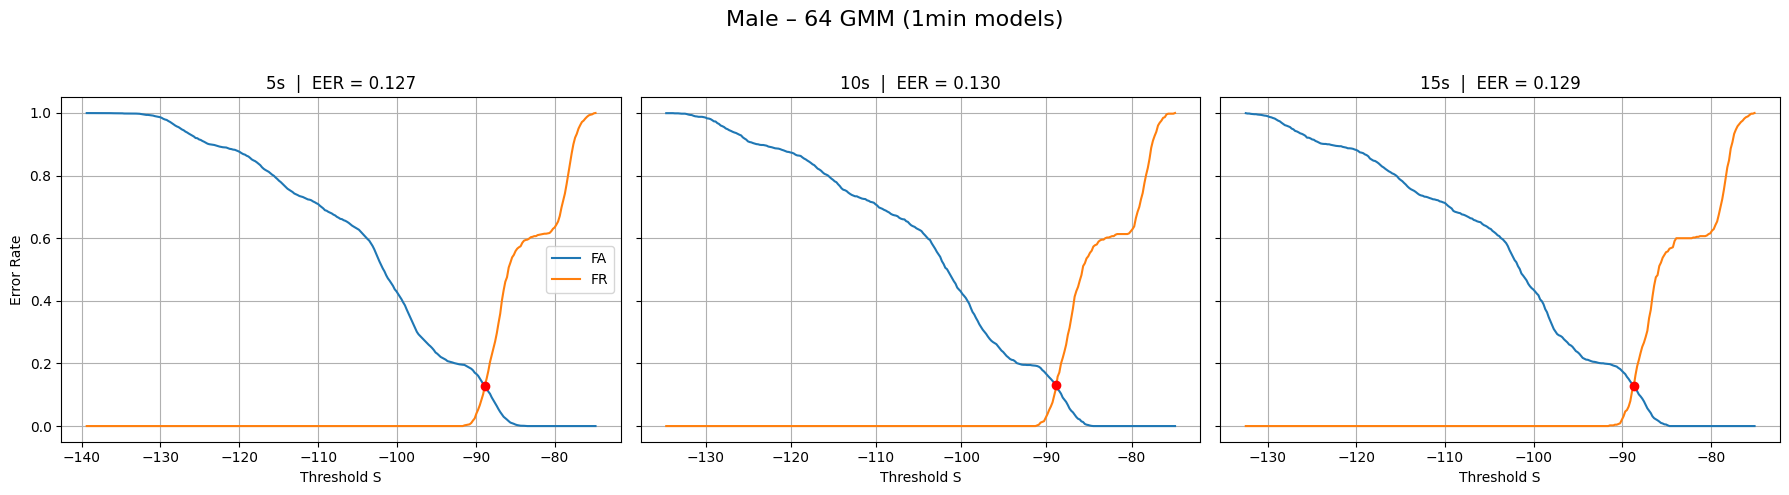

Finished: Male – 64 GMM


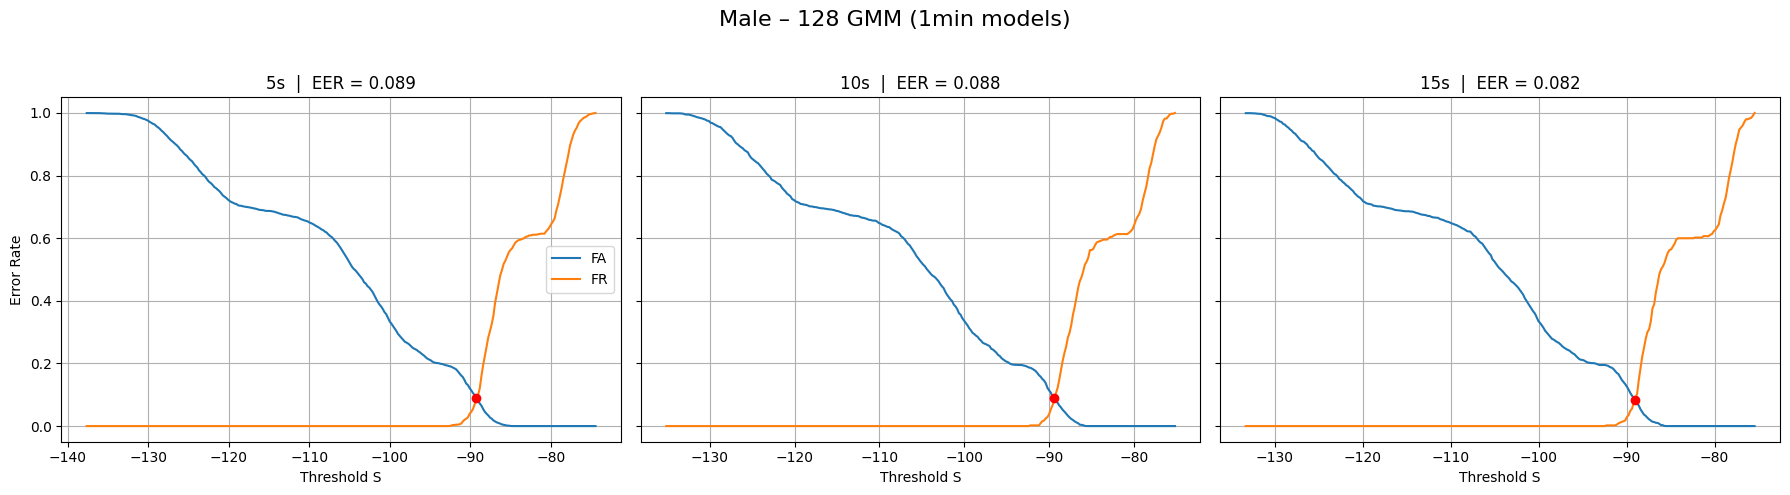

Finished: Male – 128 GMM


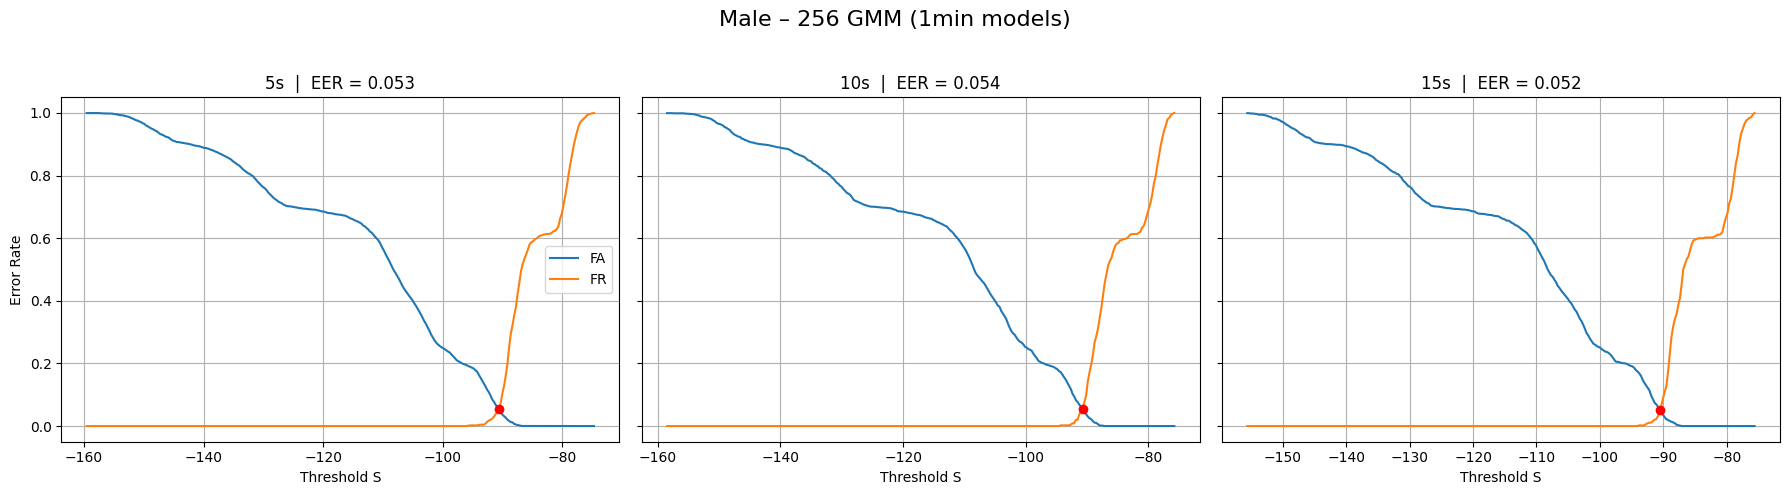

Finished: Male – 256 GMM


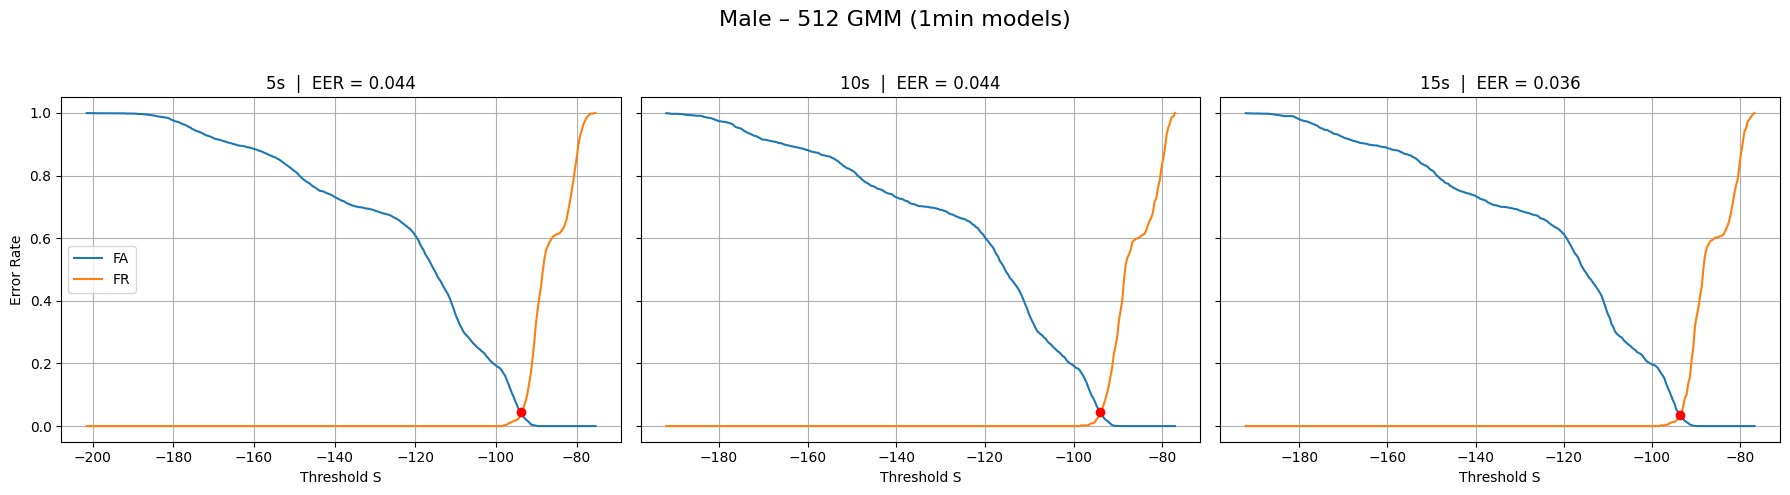

Finished: Male – 512 GMM


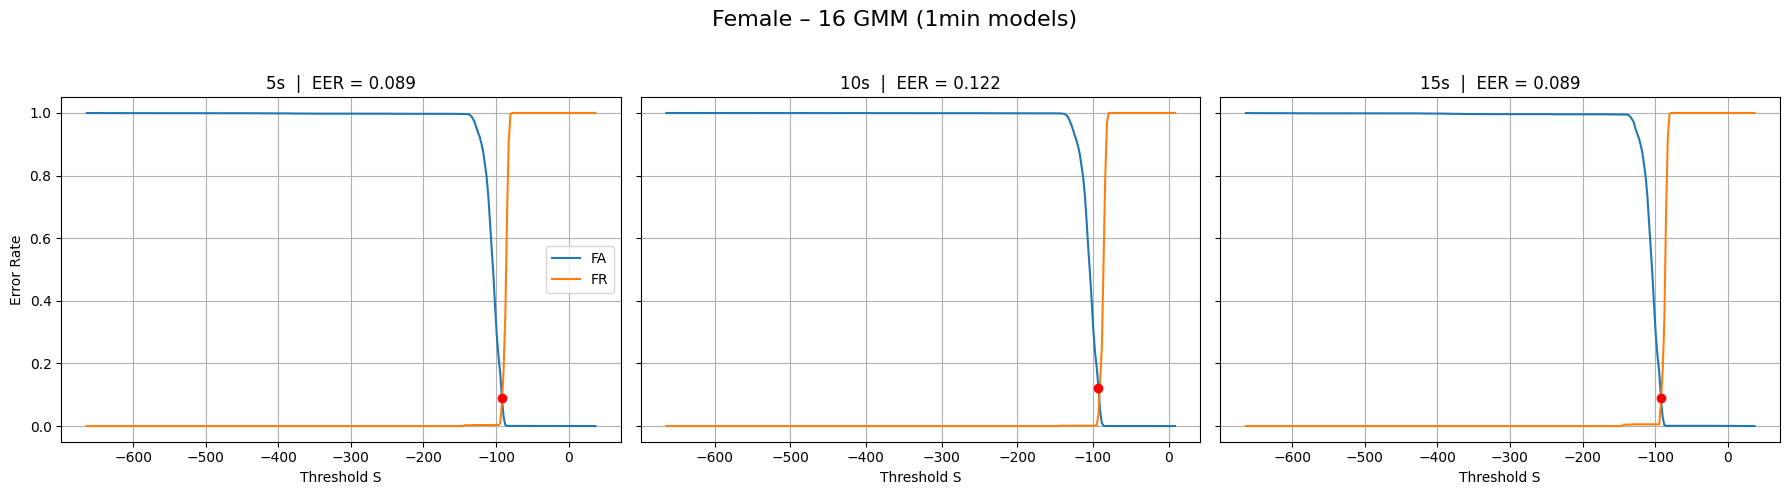

Finished: Female – 16 GMM


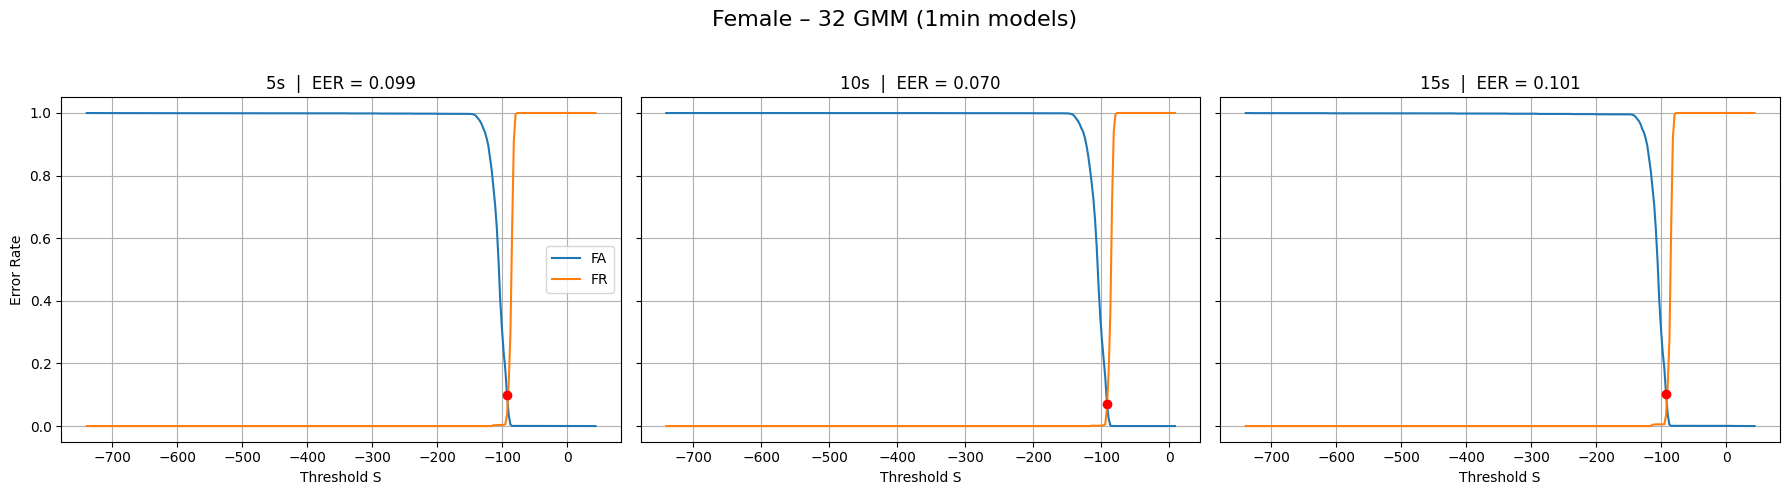

Finished: Female – 32 GMM


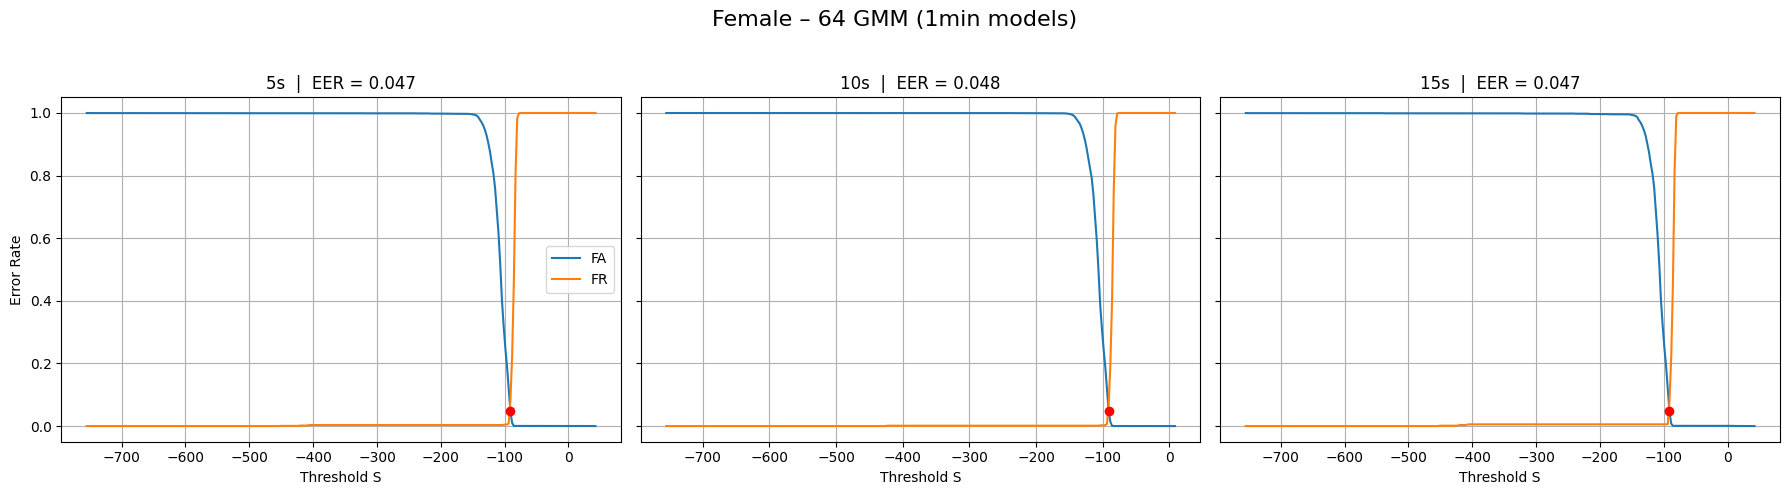

Finished: Female – 64 GMM


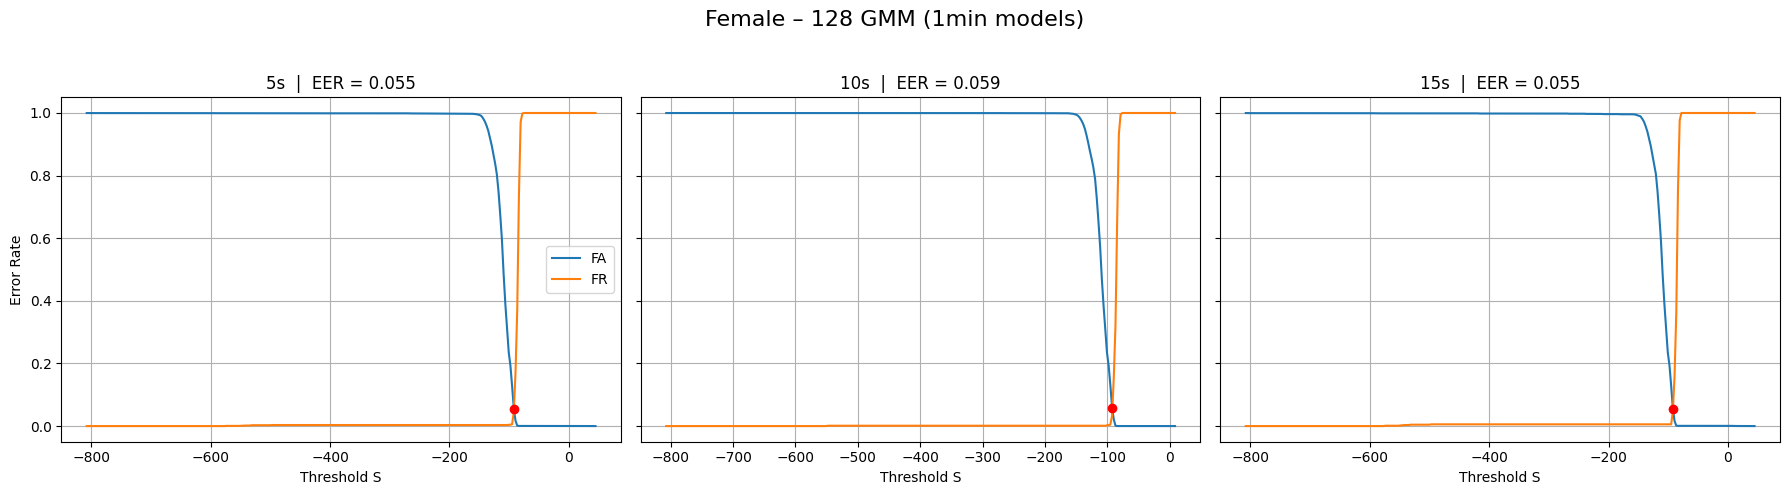

Finished: Female – 128 GMM


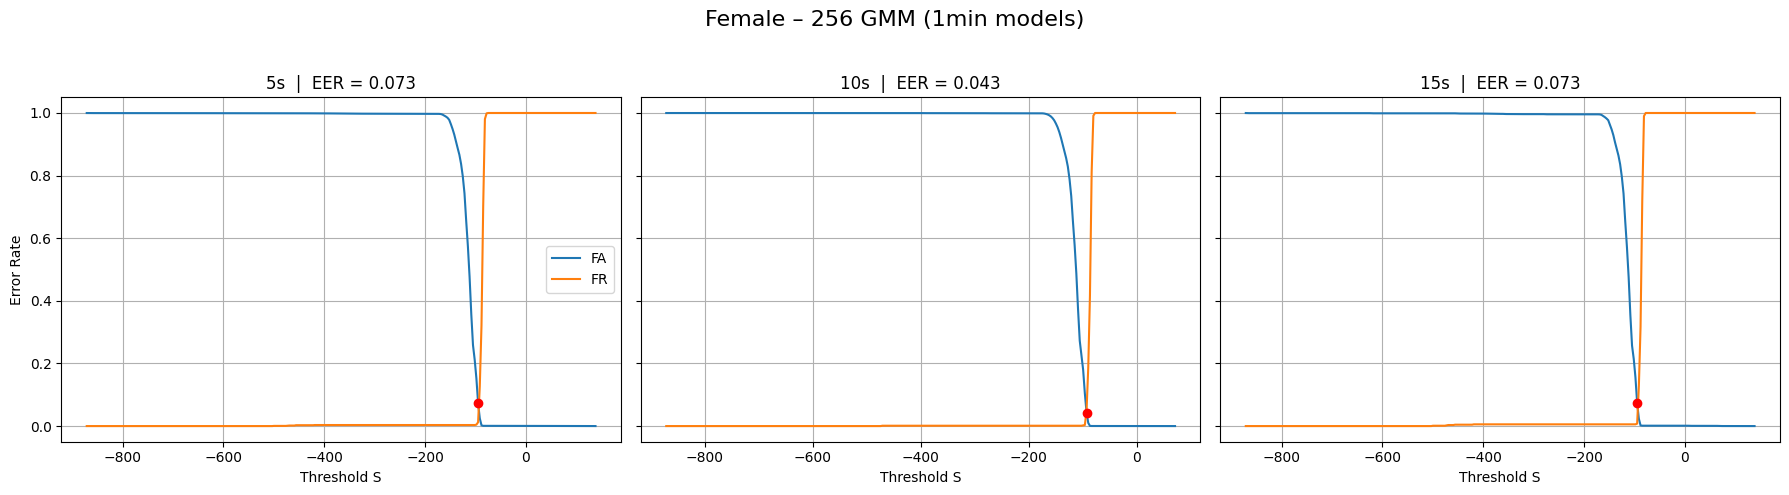

Finished: Female – 256 GMM


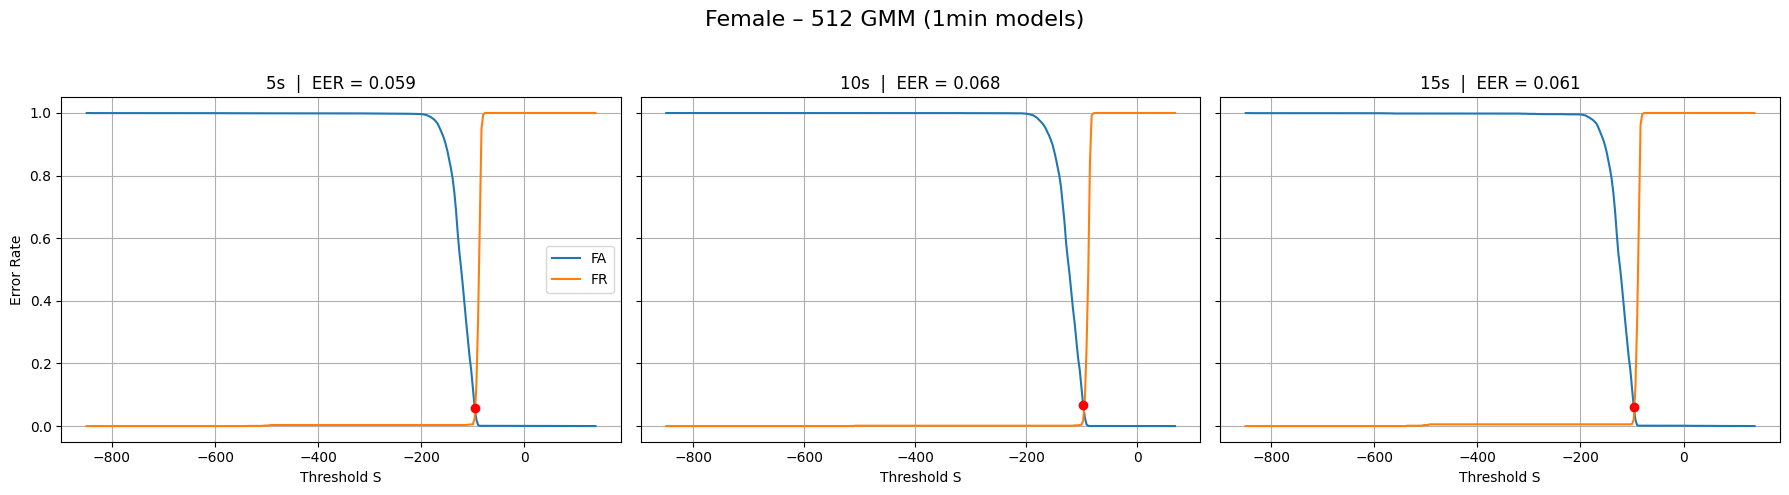

Finished: Female – 512 GMM


In [7]:
for gender in GENDERS:
    for n in COMPONENTS:

        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
        fig.suptitle(f"{gender} – {n} GMM (1min models)", fontsize=16)

        for idx_dur, duration in enumerate(DURATIONS):
            ax = axes[idx_dur]

            segments = collect_test_segments(gender, duration)
            models = load_models(gender, n)

            # Collect score range
            scores = []
            for seg in segments:
                for gmm in models.values():
                    scores.append(gmm_score(gmm, seg["mfcc"]))

            thresholds = np.linspace(min(scores), max(scores), 300)

            FA, FR = compute_fa_fr_curves(segments, models, thresholds)

            # EER
            eer_idx = np.argmin(np.abs(FA - FR))
            eer = FA[eer_idx]
            eer_th = thresholds[eer_idx]

            # Plot
            ax.plot(thresholds, FA, label="FA")
            ax.plot(thresholds, FR, label="FR")
            ax.scatter(eer_th, eer, color="red", zorder=5)

            ax.set_title(f"{duration}  |  EER = {eer:.3f}")
            ax.set_xlabel("Threshold S")
            ax.grid(True)

            if idx_dur == 0:
                ax.set_ylabel("Error Rate")

        axes[0].legend(loc="best")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        print(f"Finished: {gender} – {n} GMM")
